In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# EDA

In [2]:
import random
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

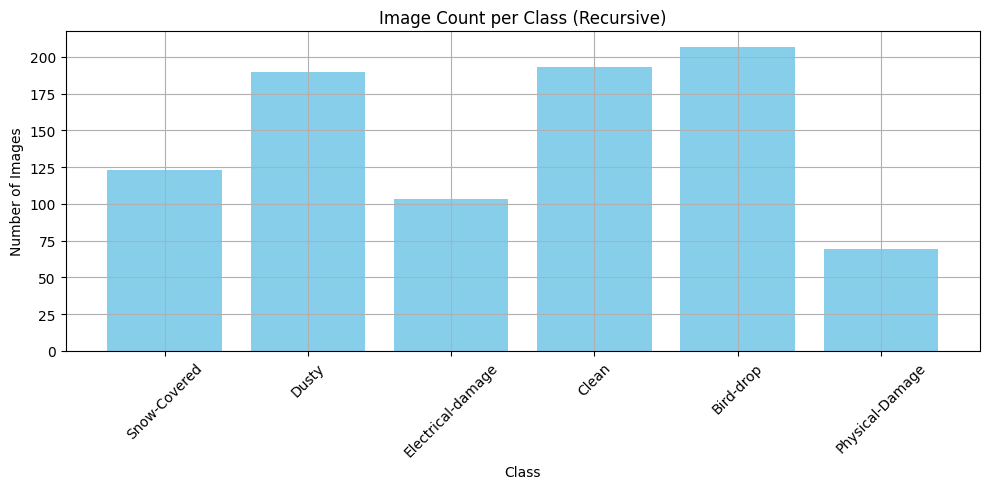

In [3]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt

data_dir = "/kaggle/input/solar-panel-images/Faulty_solar_panel/"

class_counts = defaultdict(int)
class_names = []

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        class_names.append(class_name)
        image_count = 0
        for root, dirs, files in os.walk(class_path):
            image_count += sum(1 for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png')))
        class_counts[class_name] = image_count

# Plot distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class (Recursive)')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

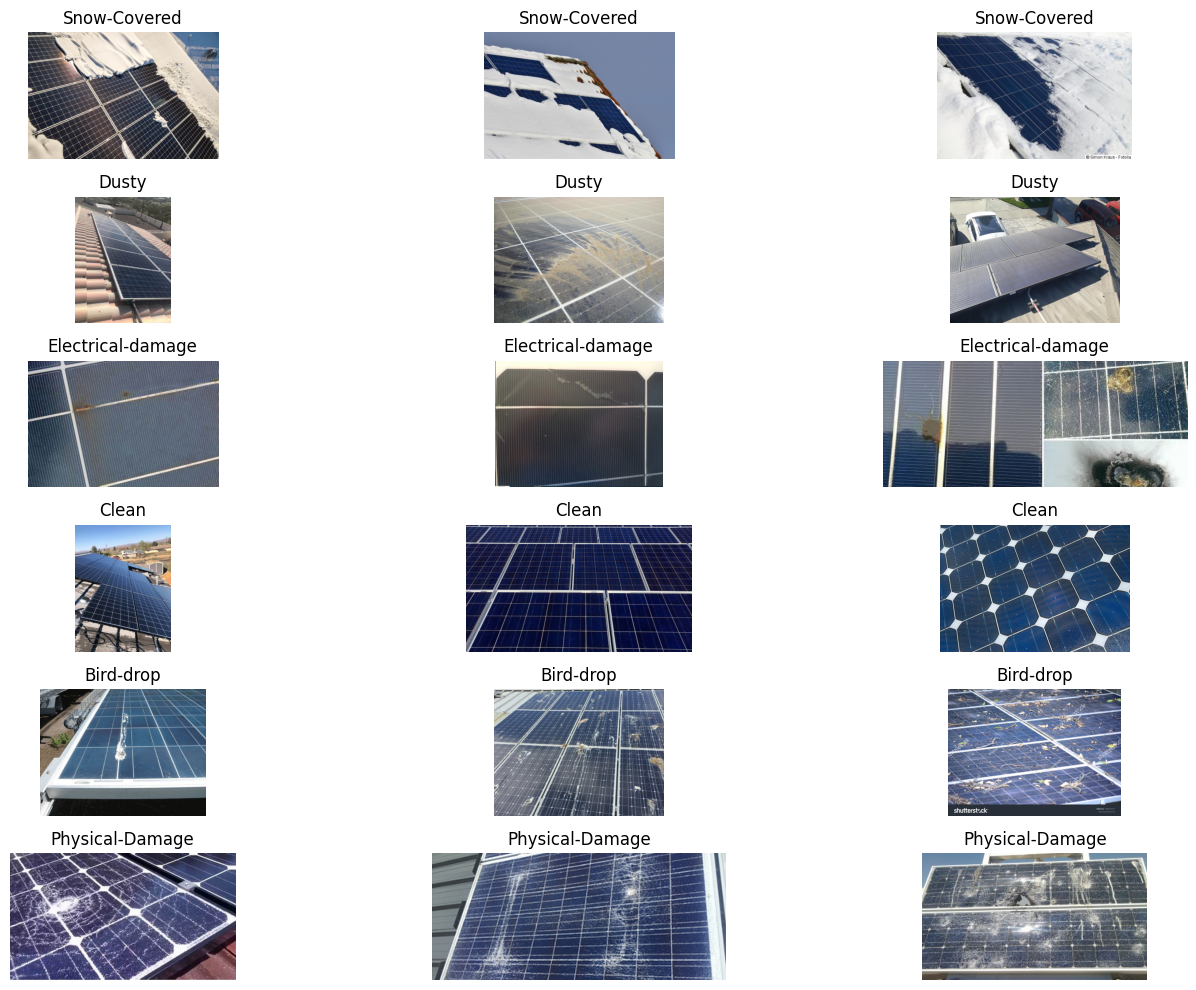

In [4]:
def get_all_images_in_class(cls_path):
    valid_ext = ('.jpg', '.jpeg', '.png','.JPG')
    return [os.path.join(root, f)
            for root, _, files in os.walk(cls_path)
            for f in files if f.lower().endswith(valid_ext)]

def show_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(class_names):
        cls_path = os.path.join(data_dir, cls)
        img_files = get_all_images_in_class(cls_path)
        for j in range(min(num_samples, len(img_files))):
            img_path = random.choice(img_files)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f'{cls}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(data_dir, class_names)


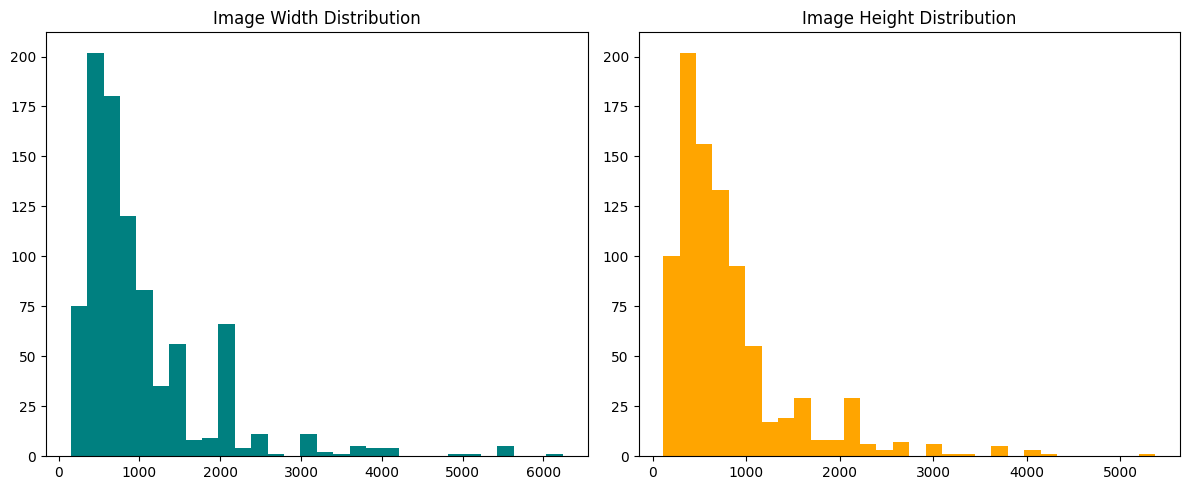

In [5]:
image_sizes = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    with Image.open(os.path.join(root, img_file)) as img:
                        image_sizes.append(img.size)
                except:
                    continue

# Plot distribution of image sizes
widths, heights = zip(*image_sizes)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='teal')
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='orange')
plt.title('Image Height Distribution')

plt.tight_layout()
plt.show()


In [6]:
corrupted_images = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img = Image.open(os.path.join(root, img_file))
                    img.verify()
                except Exception:
                    corrupted_images.append(os.path.join(root, img_file))

print(f"Found {len(corrupted_images)} corrupted images.")

Found 0 corrupted images.


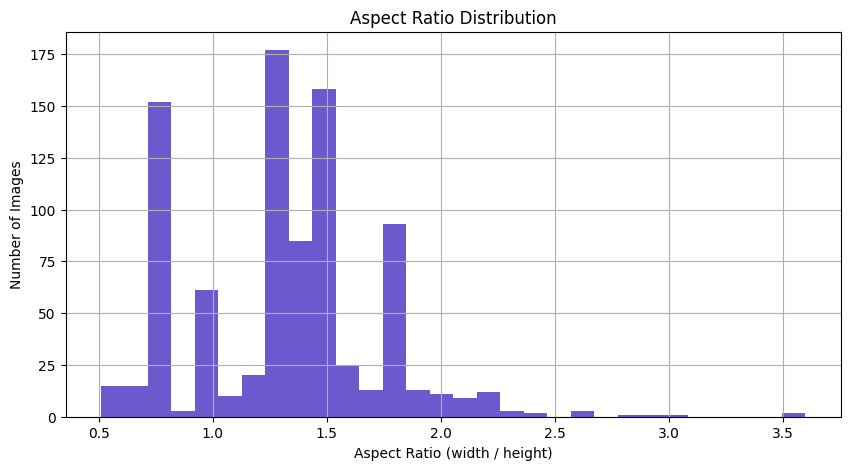

In [7]:
aspect_ratios = [w / h for (w, h) in image_sizes]

plt.figure(figsize=(10, 5))
plt.hist(aspect_ratios, bins=30, color='slateblue')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()


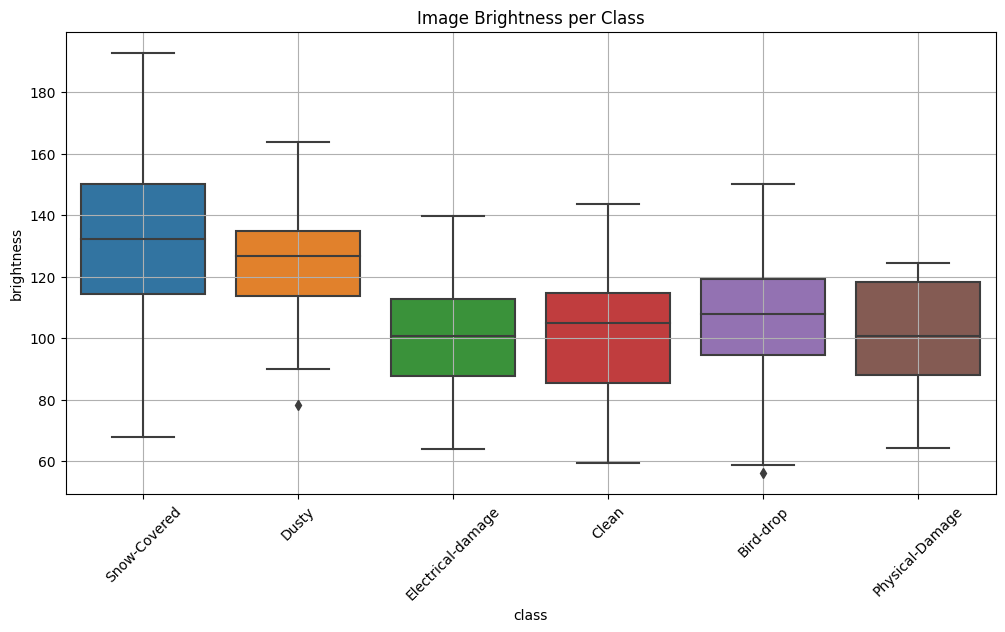

In [8]:
brightness = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    count = 0
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                if count >= 50: break  # Limit to 50 images per class
                img = cv2.imread(os.path.join(root, img_file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    brightness.append((cls, img.mean()))
                    count += 1


brightness_df = pd.DataFrame(brightness, columns=["class", "brightness"])
plt.figure(figsize=(12, 6))
sns.boxplot(data=brightness_df, x="class", y="brightness")
plt.title("Image Brightness per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


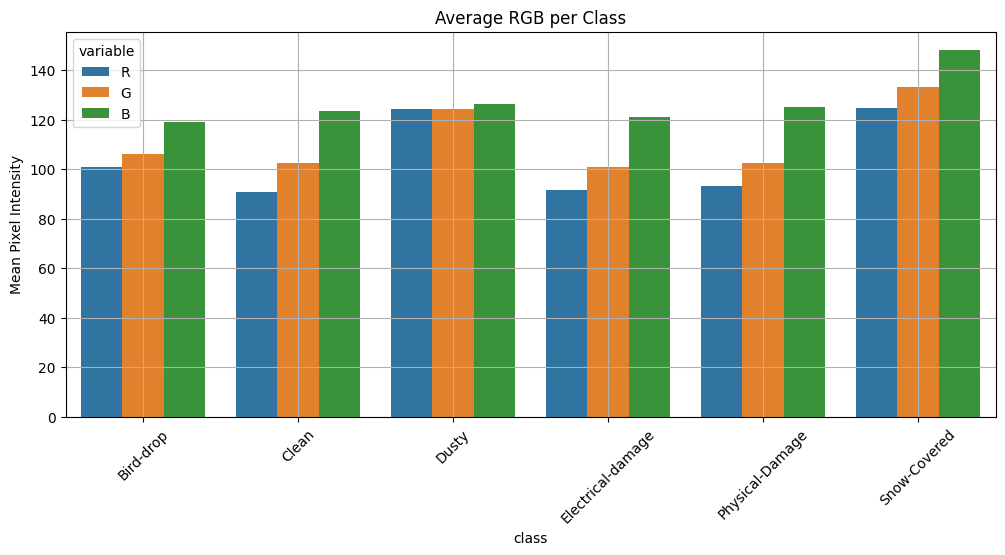

In [9]:
color_stats = {cls: [] for cls in class_names}

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    count = 0
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if count >= 50: break
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    mean_color = cv2.mean(img)[:3]  # BGR
                    color_stats[cls].append(mean_color[::-1])  # RGB
                    count += 1

# Convert to DataFrame for plotting
df_color = []
for cls, colors in color_stats.items():
    for r, g, b in colors:
        df_color.append([cls, r, g, b])

df_color = pd.DataFrame(df_color, columns=['class', 'R', 'G', 'B'])

# Mean RGB
plt.figure(figsize=(12, 5))
sns.barplot(data=df_color.groupby("class").mean(numeric_only=True).reset_index().melt(id_vars="class"),
            x="class", y="value", hue="variable")
plt.title("Average RGB per Class")
plt.xticks(rotation=45)
plt.ylabel("Mean Pixel Intensity")
plt.grid(True)
plt.show()

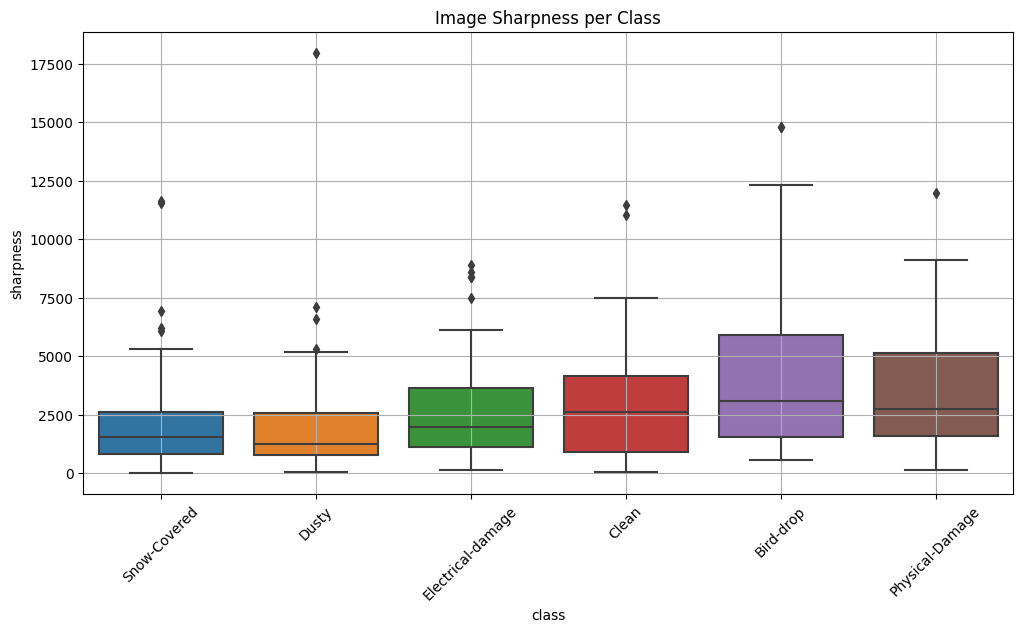

In [10]:
sharpness = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    count = 0
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if count >= 50: break
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, img_file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    sharpness_value = cv2.Laplacian(img, cv2.CV_64F).var()
                    sharpness.append((cls, sharpness_value))
                    count += 1

sharpness_df = pd.DataFrame(sharpness, columns=["class", "sharpness"])
plt.figure(figsize=(12, 6))
sns.boxplot(data=sharpness_df, x="class", y="sharpness")
plt.title("Image Sharpness per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

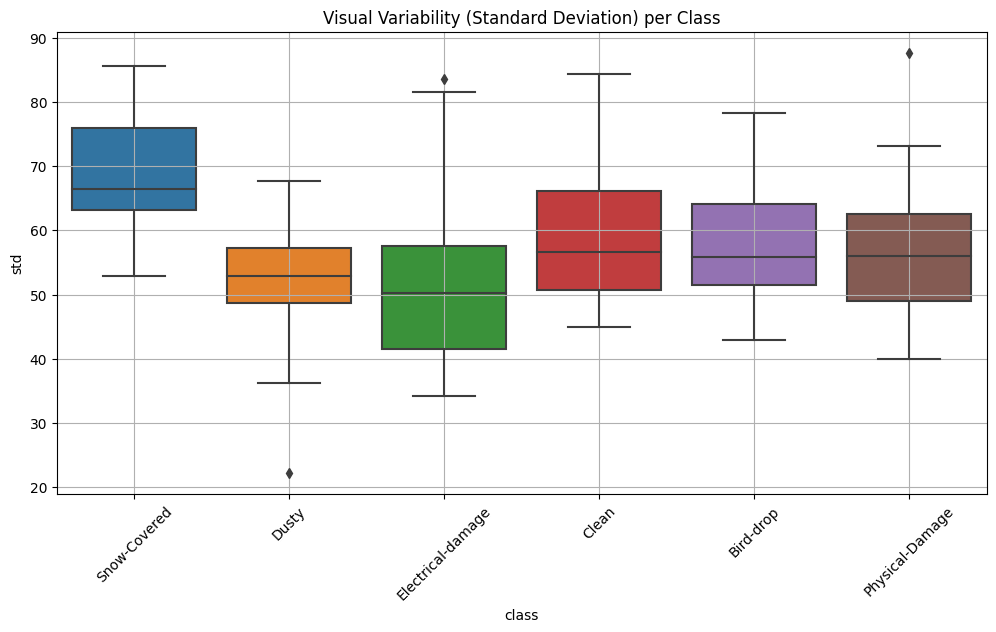

In [11]:
import numpy as np

def image_std(img):
    return np.std(img)

variability = []

for cls in class_names:
    cls_path = os.path.join(data_dir, cls)
    count = 0
    for root, _, files in os.walk(cls_path):
        for img_file in files:
            if count >= 30: break
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, img_file), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    variability.append((cls, image_std(img)))
                    count += 1

var_df = pd.DataFrame(variability, columns=["class", "std"])
plt.figure(figsize=(12, 6))
sns.boxplot(data=var_df, x="class", y="std")
plt.title("Visual Variability (Standard Deviation) per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# preprocessing

## Standardize Size & Aspect Ratio

In [12]:
from torchvision import transforms

In [13]:
from torchvision import transforms
import torchvision.transforms.functional as F
import torchvision.transforms as T

class SquarePad:
    """Pad an image to make it square by reflecting the short side."""
    def __call__(self, img):
        # img is a PIL Image
        w, h = img.size
        if w == h:
            return img
        # compute padding on left/right or top/bottom
        diff = abs(h - w)
        pad1, pad2 = diff // 2, diff - diff // 2
        # if width < height, pad left/right; else pad top/bottom
        if w < h:
            padding = (pad1, 0, pad2, 0)
        else:
            padding = (0, pad1, 0, pad2)
        img = F.to_tensor(img)
        return F.pad(img, padding, mode='reflect')

transform_base = transforms.Compose([
    transforms.Pad(padding=10, padding_mode='constant'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Normalize Pixel Intensities

In [14]:
transform_norm = transforms.Normalize(mean=[0.485,0.456,0.406],
                                      std=[0.229,0.224,0.225])
transform_train = transforms.Compose([
    *transform_base.transforms,
    transform_norm,
])

## Aggressive Data Augmentation

In [15]:
from torchvision import transforms

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.2),
    transforms.RandomRotation(30),            
    transforms.ColorJitter(brightness=0.2,   
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ToTensor(),
    transform_norm,
])


## Handle Class Imbalance

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import torch


class_names = ['Clean', 'Dusty', 'Bird-drop', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
y = []

for cls_name in class_names:
    cls_path = os.path.join(data_dir, cls_name)
    for root, _, files in os.walk(cls_path):  # Recursively go through subfolders like 'new'
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                y.append(class_to_idx[cls_name])
                

class_weights = compute_class_weight('balanced', classes=range(6), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

## Oversampling

In [17]:
from torch.utils.data import DataLoader, WeightedRandomSampler,Subset
from torchvision.datasets import ImageFolder
from collections import Counter
from sklearn.model_selection import train_test_split

full_dataset = ImageFolder(root=data_dir, transform=transform_train)
targets = [sample[1] for sample in full_dataset.samples]
indices = list(range(len(full_dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=42
)

train_dataset = Subset(
    ImageFolder(root=data_dir, transform=transform_aug),  # Now using augmentation
    train_indices
)

val_dataset = Subset(
    ImageFolder(root=data_dir, transform=transform_train),
    val_indices
)

train_targets = [full_dataset.samples[i][1] for i in train_indices]
class_counts = Counter(train_targets)
sample_weights = [1.0 / class_counts[full_dataset.samples[i][1]] for i in train_indices]

# Create sampler only for training set
sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(train_indices),
    replacement=True
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Train models

In [18]:
from collections import Counter
import numpy as np

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

print("\nTraining class distribution:")
train_class_dist = Counter(train_targets)
for cls_idx, count in train_class_dist.items():
    print(f"  Class {cls_idx} ({full_dataset.classes[cls_idx]}): {count} samples")

print("\nValidation class distribution:")
val_targets = [full_dataset.samples[i][1] for i in val_indices]
val_class_dist = Counter(val_targets)
for cls_idx, count in val_class_dist.items():
    print(f"  Class {cls_idx} ({full_dataset.classes[cls_idx]}): {count} samples")

print("\nSample weights stats (train):")
print(f"  Min weight: {np.min(sample_weights):.4f}")
print(f"  Max weight: {np.max(sample_weights):.4f}")
print(f"  Mean weight: {np.mean(sample_weights):.4f}")

# Optional: show class counts in the weighted sampler
print("\nWeightedRandomSampler samples (first 20):")
print(sample_weights[:20])

# Optional: peek at one batch from train_loader to check shapes and labels
batch = next(iter(train_loader))
images, labels = batch
print(f"\nOne batch - images shape: {images.shape}, labels: {labels}")
print(f"Label counts in batch: {Counter(labels.tolist())}")

Total dataset size: 885
Training set size: 708
Validation set size: 177

Training class distribution:
  Class 2 (Dusty): 152 samples
  Class 1 (Clean): 155 samples
  Class 5 (Snow-Covered): 98 samples
  Class 3 (Electrical-damage): 82 samples
  Class 0 (Bird-drop): 166 samples
  Class 4 (Physical-Damage): 55 samples

Validation class distribution:
  Class 1 (Clean): 38 samples
  Class 0 (Bird-drop): 41 samples
  Class 2 (Dusty): 38 samples
  Class 4 (Physical-Damage): 14 samples
  Class 5 (Snow-Covered): 25 samples
  Class 3 (Electrical-damage): 21 samples

Sample weights stats (train):
  Min weight: 0.0060
  Max weight: 0.0182
  Mean weight: 0.0085

WeightedRandomSampler samples (first 20):
[0.006578947368421052, 0.0064516129032258064, 0.01020408163265306, 0.012195121951219513, 0.01020408163265306, 0.006024096385542169, 0.01020408163265306, 0.0064516129032258064, 0.012195121951219513, 0.006024096385542169, 0.006578947368421052, 0.01020408163265306, 0.006578947368421052, 0.006451612903

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_model_weights = None  # Save best weights

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_weights = model.state_dict()  # Save best weights
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [20]:
def train_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    model.to(device)
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch [{epoch}/{epochs}]")
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                print(f"  Batch [{batch_idx + 1}/{len(train_loader)}] - Loss: {loss.item():.4f}")
        
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        print(f"→ Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"→ Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
            
    if early_stopping.best_model_weights is not None:
        model.load_state_dict(early_stopping.best_model_weights)
        print("✅ Restored best model weights.")
    
    return history


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

def class_report_and_heatmap(model):
    true_labels = []
    predicted_labels = []
    class_names = ['Bird-drop', 'Clean','Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


    with torch.no_grad():
        for inputs, labels in val_loader: 
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            predicted_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print(classification_report(true_labels, predicted_labels, target_names=class_names, digits=4))
    

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [22]:
def plot_training(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Train a CNN model from strach

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SolarPanelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SolarPanelCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda



Epoch [1/20]
  Batch [10/23] - Loss: 2.1921
  Batch [20/23] - Loss: 1.8316
  Batch [23/23] - Loss: 1.7410
→ Training Loss: 2.7082, Training Accuracy: 0.2486
→ Validation Loss: 1.6358, Validation Accuracy: 0.2768

Epoch [2/20]
  Batch [10/23] - Loss: 1.5013
  Batch [20/23] - Loss: 1.4931
  Batch [23/23] - Loss: 1.8170
→ Training Loss: 1.5587, Training Accuracy: 0.3376
→ Validation Loss: 1.3990, Validation Accuracy: 0.3220

Epoch [3/20]
  Batch [10/23] - Loss: 1.3926
  Batch [20/23] - Loss: 1.4406
  Batch [23/23] - Loss: 0.7162
→ Training Loss: 1.4417, Training Accuracy: 0.3898
→ Validation Loss: 1.3806, Validation Accuracy: 0.3729

Epoch [4/20]
  Batch [10/23] - Loss: 1.2578
  Batch [20/23] - Loss: 1.3680
  Batch [23/23] - Loss: 1.5112
→ Training Loss: 1.3904, Training Accuracy: 0.3983
→ Validation Loss: 1.3882, Validation Accuracy: 0.4576

Epoch [5/20]
  Batch [10/23] - Loss: 1.4577
  Batch [20/23] - Loss: 1.5007
  Batch [23/23] - Loss: 1.3168
→ Training Loss: 1.3549, Training Accurac

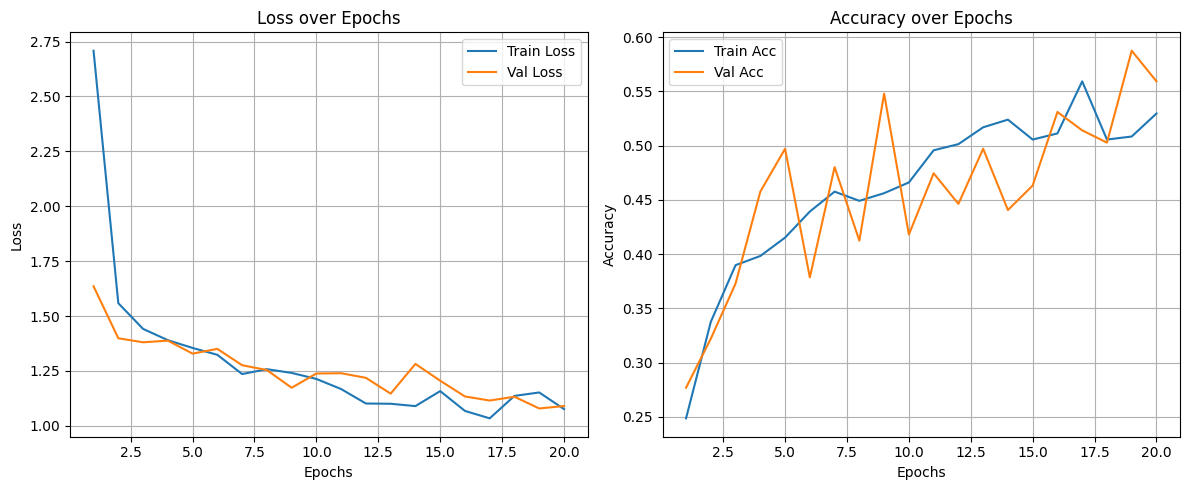

                   precision    recall  f1-score   support

        Bird-drop     0.5238    0.5366    0.5301        41
            Clean     0.8182    0.2368    0.3673        38
            Dusty     0.6667    0.6842    0.6753        38
Electrical-damage     0.5152    0.8095    0.6296        21
  Physical-Damage     0.2593    0.5000    0.3415        14
     Snow-Covered     0.7200    0.7200    0.7200        25

         accuracy                         0.5593       177
        macro avg     0.5838    0.5812    0.5440       177
     weighted avg     0.6234    0.5593    0.5501       177



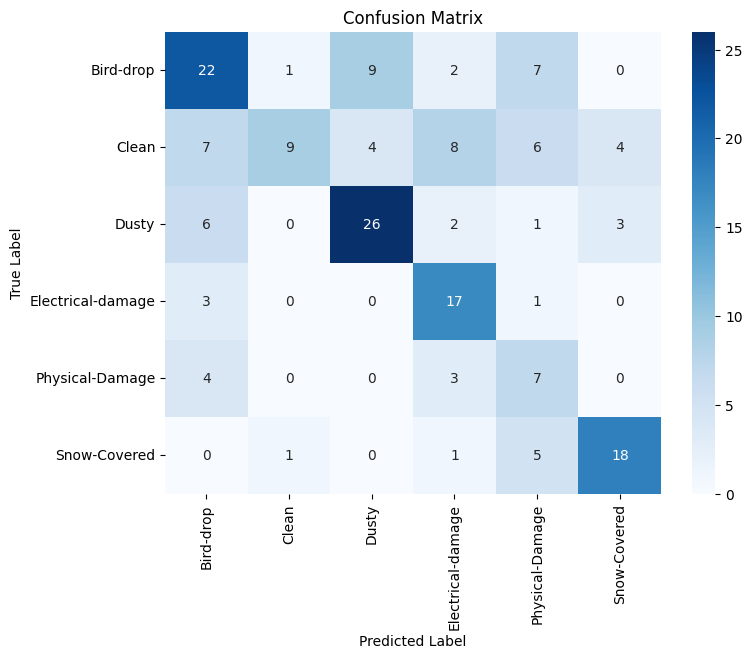

In [59]:
cmodel = SolarPanelCNN(num_classes=6)
optimizer = torch.optim.Adam(cmodel.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

chistory = train_validate(cmodel, train_loader, val_loader, criterion, optimizer, device, epochs=20)
plot_training(chistory)
class_report_and_heatmap(cmodel)

In [27]:
class ImprovedSolarPanelCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ImprovedSolarPanelCNN, self).__init__()
        
        # Enhanced convolutional blocks
        self.conv_block = nn.Sequential(
            # Block 1: Larger receptive field
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # Increased kernel size
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),  # LeakyReLU for better gradient flow
            nn.MaxPool2d(2),
            
            # Block 2: Increased channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            
            # Block 3: Added depth
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            
            # New block 4: Additional layer for better feature extraction
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            
            # Global pooling instead of flattening large feature maps
            nn.AdaptiveAvgPool2d(1)
        )
        
        # More efficient classifier
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),  # Slightly higher dropout for regularization
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x


Epoch [1/20]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5c541891c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5c541891c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

  Batch [10/23] - Loss: 1.4844
  Batch [20/23] - Loss: 1.3499
  Batch [23/23] - Loss: 1.2869
→ Training Loss: 1.5753, Training Accuracy: 0.2924
→ Validation Loss: 1.7462, Validation Accuracy: 0.2260

Epoch [2/20]
  Batch [10/23] - Loss: 1.1238
  Batch [20/23] - Loss: 1.2520
  Batch [23/23] - Loss: 1.7920
→ Training Loss: 1.3524, Training Accuracy: 0.3644
→ Validation Loss: 1.5120, Validation Accuracy: 0.3616

Epoch [3/20]
  Batch [10/23] - Loss: 1.0987
  Batch [20/23] - Loss: 1.1371
  Batch [23/23] - Loss: 0.6545
→ Training Loss: 1.2227, Training Accuracy: 0.4788
→ Validation Loss: 1.4004, Validation Accuracy: 0.4576

Epoch [4/20]
  Batch [10/23] - Loss: 1.2501
  Batch [20/23] - Loss: 1.2163
  Batch [23/23] - Loss: 1.8208
→ Training Loss: 1.2246, Training Accuracy: 0.4915
→ Validation Loss: 1.8153, Validation Accuracy: 0.3559

Epoch [5/20]
  Batch [10/23] - Loss: 0.9827
  Batch [20/23] - Loss: 1.0867
  Batch [23/23] - Loss: 1.1403
→ Training Loss: 1.1719, Training Accuracy: 0.4788
→ Va

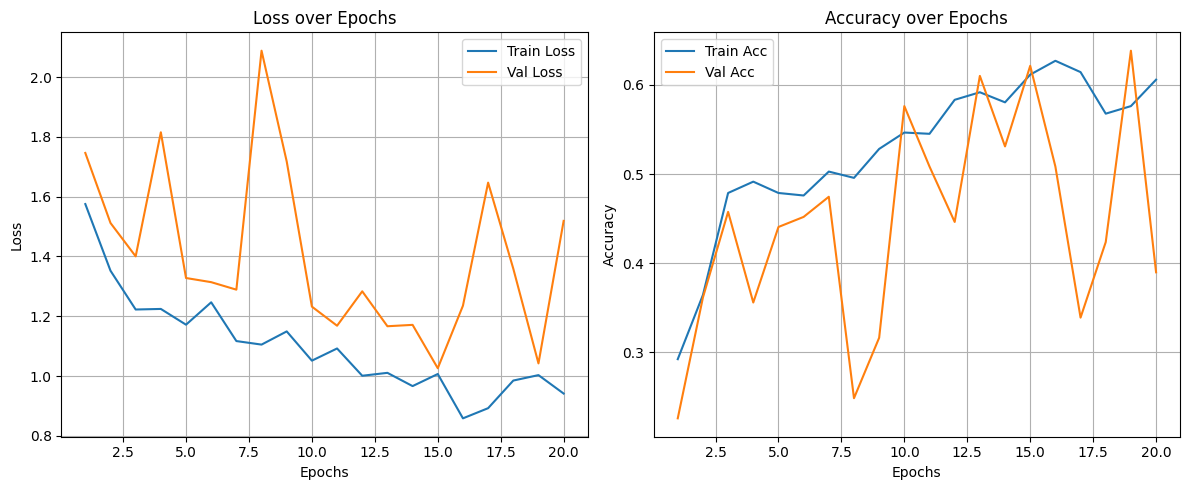

                   precision    recall  f1-score   support

        Bird-drop     0.7000    0.1707    0.2745        41
            Clean     1.0000    0.1316    0.2326        38
            Dusty     0.8667    0.3421    0.4906        38
Electrical-damage     1.0000    0.5238    0.6875        21
  Physical-Damage     0.1200    0.6429    0.2022        14
     Snow-Covered     0.3934    0.9600    0.5581        25

         accuracy                         0.3898       177
        macro avg     0.6800    0.4618    0.4076       177
     weighted avg     0.7466    0.3898    0.3952       177



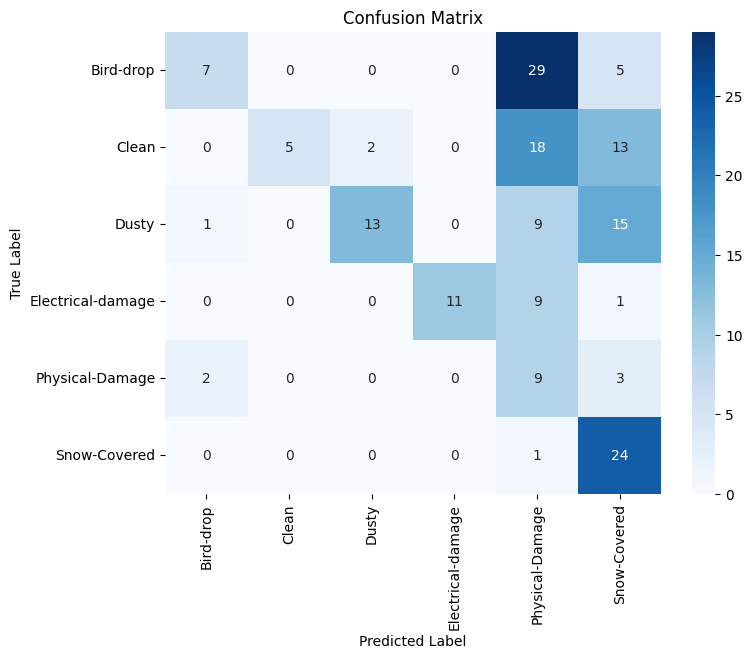

In [60]:
cimodel = ImprovedSolarPanelCNN(num_classes=6)

optimizer = torch.optim.AdamW(  
    cimodel.parameters(),
    lr=0.001,      
    weight_decay=0.01  
)

cirhistory = train_validate(cimodel, train_loader, val_loader, criterion, optimizer, device, epochs=20)
plot_training(cirhistory)
class_report_and_heatmap(cimodel)

## Pretained model

In [30]:
import torch.nn as nn
from torchvision import models
import torch

class ResNetCustom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained ResNet50
        base_model = models.resnet50(weights="IMAGENET1K_V1")

        # Freeze all layers
        for param in base_model.parameters():
            param.requires_grad = False

        for name, param in base_model.named_parameters():
            if "layer4" in name:
                param.requires_grad = True

        # Extract feature layers up to the last convolutional block
        self.features = nn.Sequential(*list(base_model.children())[:-2])

        # Custom classification head
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, num_classes)
        )

        # Optional: initialize weights for the classifier
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)      # [batch_size, 2048, H, W]
        x = self.pool(x)          # [batch_size, 2048, 1, 1]
        x = self.flatten(x)       # [batch_size, 2048]
        x = self.classifier(x)    # [batch_size, num_classes]
        return x

    def _initialize_weights(self):
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]



Epoch [1/20]
  Batch [10/23] - Loss: 1.6185
  Batch [20/23] - Loss: 1.5788
  Batch [23/23] - Loss: 1.6138
→ Training Loss: 1.6048, Training Accuracy: 0.3955
→ Validation Loss: 0.9646, Validation Accuracy: 0.6723

Epoch [2/20]
  Batch [10/23] - Loss: 0.6624
  Batch [20/23] - Loss: 0.7205
  Batch [23/23] - Loss: 1.2259
→ Training Loss: 0.8469, Training Accuracy: 0.6497
→ Validation Loss: 0.7526, Validation Accuracy: 0.6723

Epoch [3/20]
  Batch [10/23] - Loss: 1.0179
  Batch [20/23] - Loss: 0.5852
  Batch [23/23] - Loss: 3.2857
→ Training Loss: 0.6710, Training Accuracy: 0.6921
→ Validation Loss: 0.6836, Validation Accuracy: 0.7175

Epoch [4/20]
  Batch [10/23] - Loss: 0.5469
  Batch [20/23] - Loss: 0.6256
  Batch [23/23] - Loss: 0.4290
→ Training Loss: 0.5683, Training Accuracy: 0.7359
→ Validation Loss: 0.5678, Validation Accuracy: 0.7684

Epoch [5/20]
  Batch [10/23] - Loss: 0.3736
  Batch [20/23] - Loss: 0.5992
  Batch [23/23] - Loss: 0.5479
→ Training Loss: 0.5244, Training Accurac

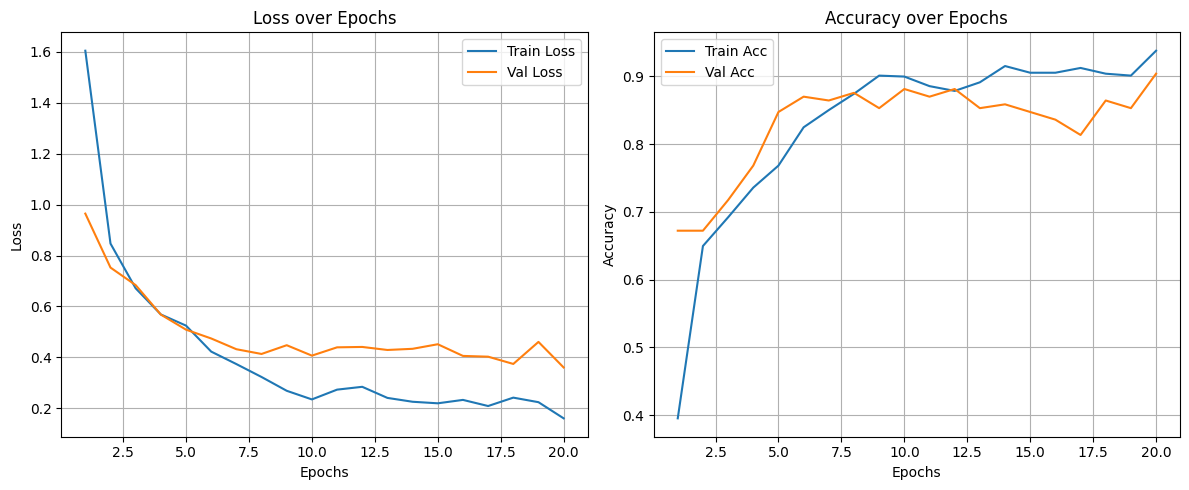

                   precision    recall  f1-score   support

        Bird-drop     0.8837    0.9268    0.9048        41
            Clean     0.9444    0.8947    0.9189        38
            Dusty     0.8500    0.8947    0.8718        38
Electrical-damage     0.9048    0.9048    0.9048        21
  Physical-Damage     0.8462    0.7857    0.8148        14
     Snow-Covered     1.0000    0.9600    0.9796        25

         accuracy                         0.9040       177
        macro avg     0.9048    0.8945    0.8991       177
     weighted avg     0.9055    0.9040    0.9042       177



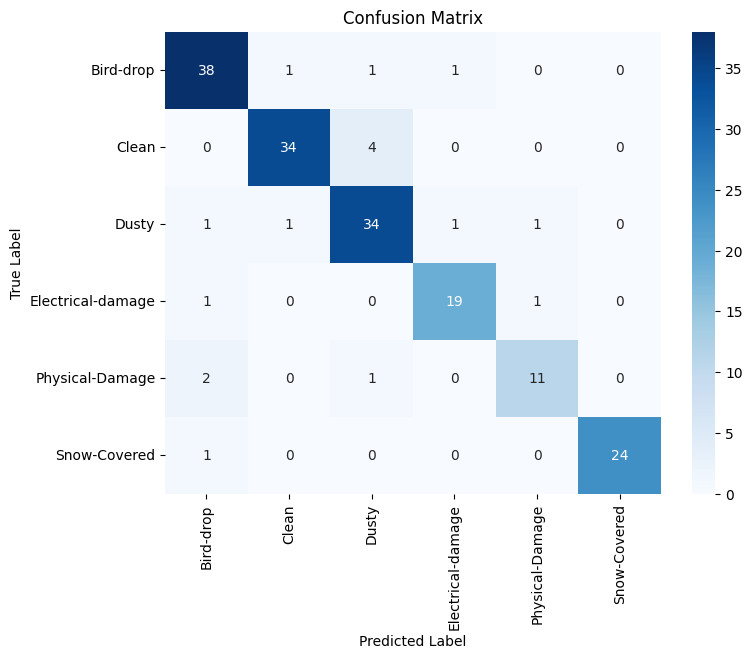

In [31]:
num_classes = len(full_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rmodel = ResNetCustom(num_classes=num_classes)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(rmodel.parameters(), lr=1e-4, weight_decay=1e-2)

rhistory = train_validate(rmodel, train_loader, val_loader, criterion, optimizer, device, epochs=20)
plot_training(rhistory)
class_report_and_heatmap(rmodel)

# Real testing

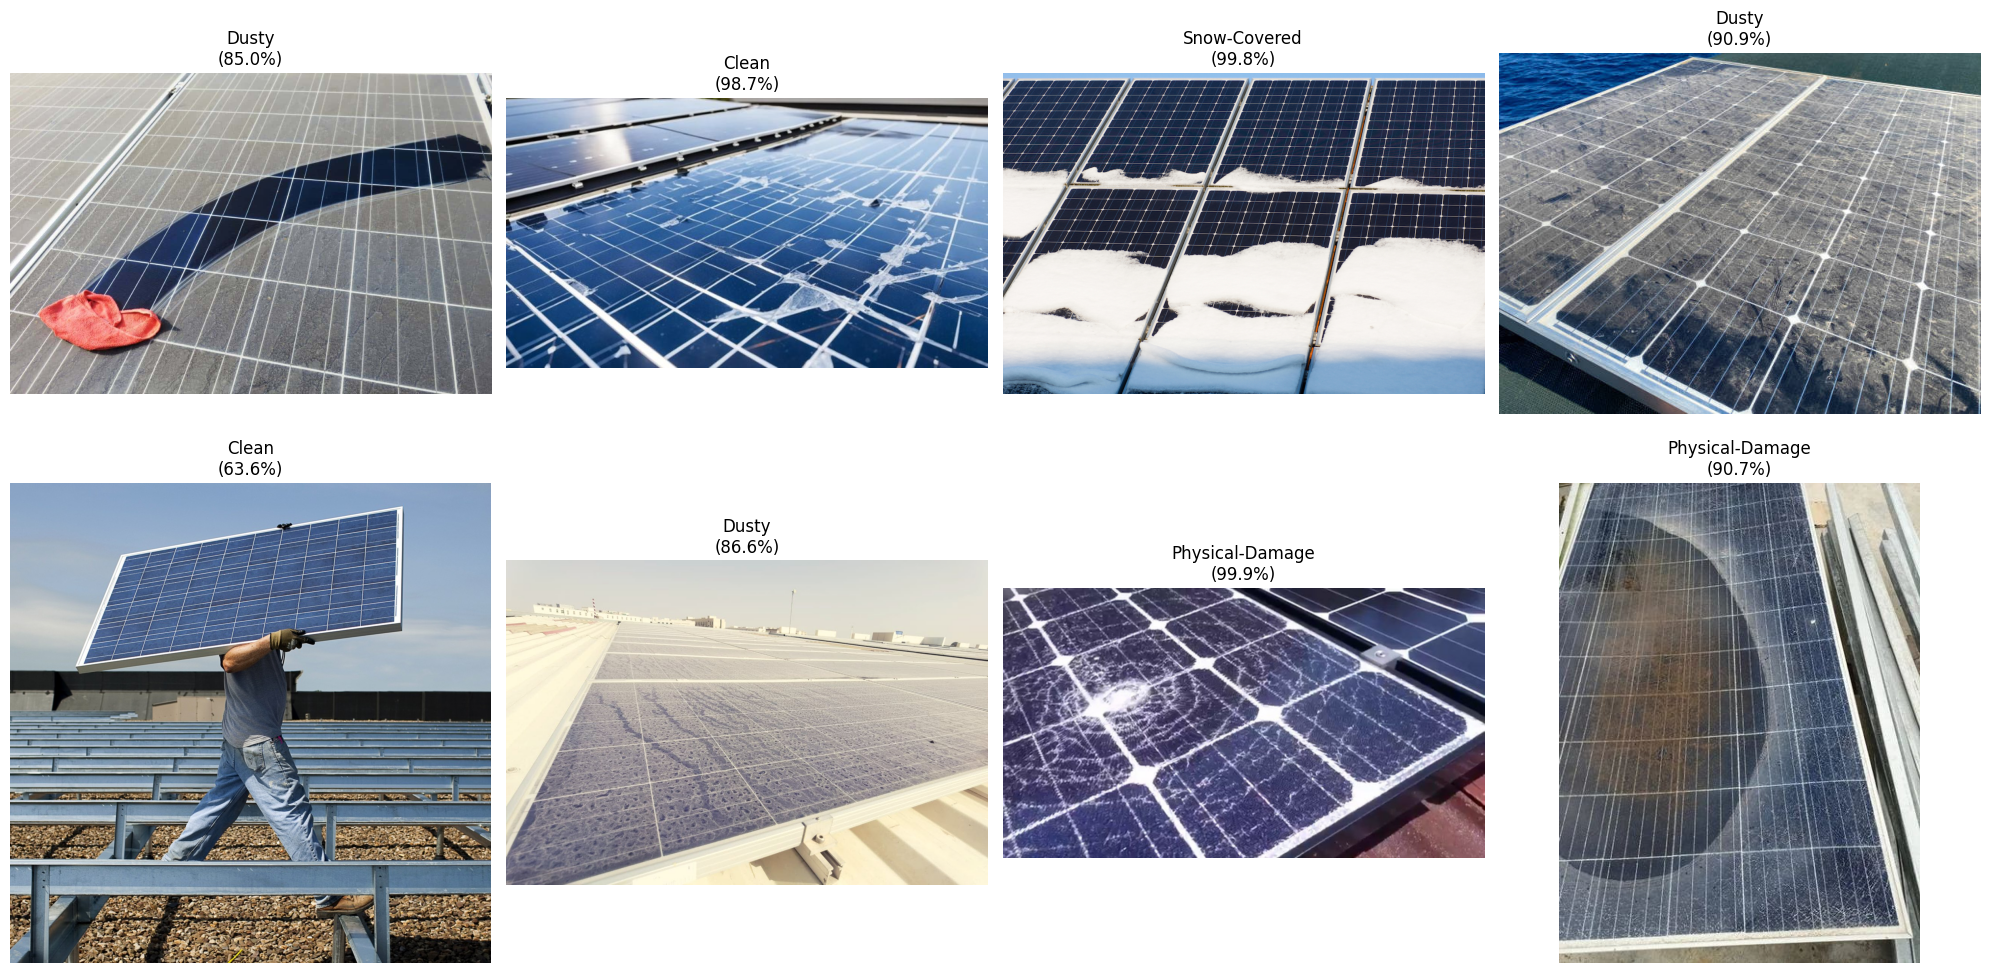

In [62]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Your class names
class_names = ['Bird-drop', 'Clean','Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

# Function to predict from a single URL
def predict_image_from_url(model, url, transform, class_names, device='cuda'):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze()
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item()

    return img, class_names[pred_class], confidence, probs.cpu().tolist()

# Image URLs
image_urls = [
    "https://www.kingenergy.com/wp-content/uploads/2023/05/Blog-Image-1.jpg",
    "https://variatesolar.com/wp-content/uploads/2024/06/Avoid-Costly-Damage-to-Solar-Panels_-Essential-Maintenance-Guide.jpeg",
    "https://www.drewssolar.com/wp-content/uploads/2025/01/image-asset.jpeg",
    "https://media.istockphoto.com/id/1350683183/photo/low-angle-view-and-close-up-of-dusty-solar-panel.jpg?s=612x612&w=0&k=20&c=TdC1oicGBkgQb82pvyqoeskUnnoS4Arf8S9qXJNHKwc=",
    "https://cdn.theatlantic.com/thumbor/4a4JroHlmOrxdAyyMxDrl3YILrw=/1050x0:3750x2700/1080x1080/media/img/mt/2023/10/solar_energy/original.jpg",
    "https://images.prismic.io/chemitek-website/66b1879c-3cb9-4c8e-a709-994a25f501fb_Newsletter+Cover+%282%29.png?auto=compress,format",
    "https://regenpower.com/wp-content/uploads/2021/01/solar-damages-1024x576.jpg",
    "https://5.imimg.com/data5/ANDROID/Default/2023/2/TN/BI/VS/39364804/product-jpeg-500x500.jpg"
]

# Predict and store results
results = []
for url in image_urls:
    img, pred_label, confidence, probs = predict_image_from_url(
        model=rmodel,
        url=url,
        transform=transform_train,
        class_names=class_names,
        device=device
    )
    results.append((img, pred_label, confidence, probs))

# Plot all in a grid
n = len(results)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(5 * cols, 5 * rows))

for i, (img, label, conf, _) in enumerate(results):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{label}\n({conf:.1%})", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()
